In [1]:
import models
import audio_utils
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import librosa
import torch.nn as nn
import os
import random
import pandas as pd
import numpy as np

In [2]:
rand_fn = '../speechRemoval/fin_dataframe.csv'
df = pd.read_csv(rand_fn)

f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
snr = [5]

noise = audio_utils.add_two_noise([f1,f2], snr)
feats_ = audio_utils.get_random_audioFeatures(noise)

f1, f2

('../audioData/NIGENS/NIGENS/footsteps/Footsteps-Carpet-Boots-Walk-1+Walker-Close-Take2_UFC-DVD-1-0079.wav',
 '../audioData/NIGENS/NIGENS/alarm/ElectronicAlarm+L2SF1_03_3.wav')

In [3]:
encoder = models.logMelAE()
encoder.load_state_dict(torch.load('models/logMelAE_model_02.pt'))

<All keys matched successfully>

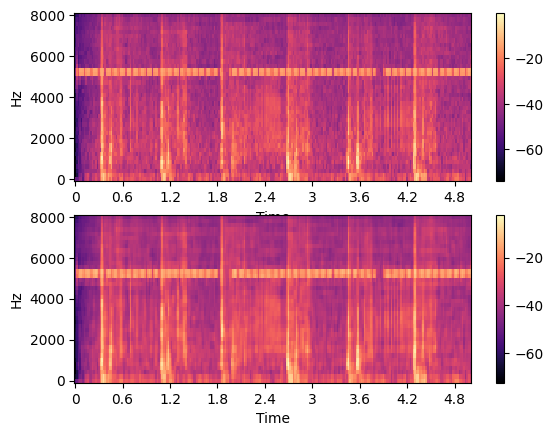

In [4]:
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000
N_MELS = 40
N_FFT = int(SAMPLE_RATE * 0.04)
HOP_LEN = int(SAMPLE_RATE * 0.02)

plt.subplot(2,1,1)
librosa.display.specshow(feats_.squeeze().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(encoder(feats_).squeeze().detach().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()

In [5]:
labels_list = df['label1'].unique()
labels_list.sort()

lab_key = [i for i in range(0, len(labels_list))]
lab_dict = {labels_list[i]:lab_key[i] for i in range(0, len(labels_list))}
#lab_dict['silence'] = 10

In [6]:
len([0 for i in range(0,10)]) == len(lab_dict)

True

In [94]:
[df.iloc[5, 0], df.iloc[5,1]]

['../audioData/NIGENS/NIGENS/phone/TELEPHONE-ELECTRONIC_GEN-HDF-22874.wav',
 '../audioData/NIGENS/NIGENS/piano/Piano+2017_58_5.wav']

In [7]:
class sedDataset(Dataset):

    def __init__(self, dataframe):
        self.dataset_df = dataframe

    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, index):

        fil_list = [self.dataset_df.iloc[index, 0], self.dataset_df.iloc[index, 1]]
        lab1 = lab_dict[self.dataset_df.iloc[index, 2]]
        lab2 = lab_dict[self.dataset_df.iloc[index, 3]]
        
        noise = audio_utils.add_two_noise(fil_list, [5])
        feats = audio_utils.get_random_audioFeatures(noise)
        
        if torch.isnan(noise).any():
            noise = torch.zeros(noise.shape)
            lab1 = lab_dict['silence']
            lab2 = lab_dict['silence']
            feats = torch.zeros(feats.shape)
            
               
        labels = [0 for i in range(0,11)]
        labels[lab1] = 1
        labels[lab2] = 1
        labels = torch.Tensor(labels)
        
        return feats, labels

In [8]:
split = (int)(len(df)*0.8)

train_dataset = sedDataset(df[0:split])
test_dataset = sedDataset(df[split:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [10]:
sad = torch.randn([16,10,63])

decoder = nn.Sequential(nn.Conv2d(16, 8, kernel_size=3, stride=1),
                        nn.ReLU(),
                        nn.Conv2d(8, 4, kernel_size=3, stride=1),
                        nn.ReLU(),
                        nn.Conv2d(4, 1, kernel_size=3, stride=1),
                        nn.ReLU(),
                        nn.Flatten(),
                        nn.Linear(228, 400),
                        nn.ReLU(),
                        nn.Linear(400, 800),
                        nn.ReLU(),
                        nn.Linear(800, 800),
                        nn.ReLU(),
                        nn.Linear(800, 600),
                        nn.ReLU(),
                        nn.Linear(600, 300),
                        nn.ReLU(),
                        nn.Linear(300, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 11),
                        nn.ReLU()
                        )

decoder(sad).shape

torch.Size([1, 11])

In [26]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

class AEDClassifier(nn.Module):

    def __init__(self):
        super(AEDClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(228, 400),
            nn.ReLU(),
            nn.Linear(400, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 11),
            nn.ReLU()
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.classifier(x)
        #y = self.sigmoid(x)

        return x

In [27]:
sas = torch.rand([16,10,63])

AEDClassifier()(sas)

tensor([[0.0040, 0.0851, 0.0000, 0.0000, 0.0083, 0.0000, 0.0000, 0.1459, 0.0000,
         0.0239, 0.0000]], grad_fn=<ReluBackward0>)

In [34]:
sed_classifier = AEDClassifier()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.SGD(sed_classifier.parameters(), lr=0.001)

In [35]:
import statistics

sed_classifier = sed_classifier.to(device)
encoder = encoder.to(device)

epochs = 10

for epoch in range(0, epochs):
    loc_list = []

    for data in train_loader:
        sed_classifier.train()
        inputs, labes = data

        inputs = inputs.to(device)
        encoder.eval()
        with torch.no_grad():
            preds = encoder.encoder(inputs)
        input = preds
        if not torch.isnan(input).any():
            labes = labes.to(device)

            output = sed_classifier(input)
            #print(output.shape, labes.shape)
            loss = loss_fn(output, labes)

            optimizer.zero_grad()
            if not torch.isnan(loss).any():
                loss.backward()
                loc_list.append(loss.item())    

    print(f"Epoch [{epoch+1}/{epochs}] Loss: [{statistics.mean(loc_list)}]")

Epoch [1/10] Loss: [0.7224815111160279]
Epoch [2/10] Loss: [0.7224815073013305]
Epoch [3/10] Loss: [0.7224815106391906]
Epoch [4/10] Loss: [0.7224815125465394]
Epoch [5/10] Loss: [0.7224815125465394]
Epoch [6/10] Loss: [0.7224815073013305]
Epoch [7/10] Loss: [0.7224815106391906]
Epoch [8/10] Loss: [0.7224815099239349]
Epoch [9/10] Loss: [0.7224815127849579]
Epoch [10/10] Loss: [0.7224815084934234]


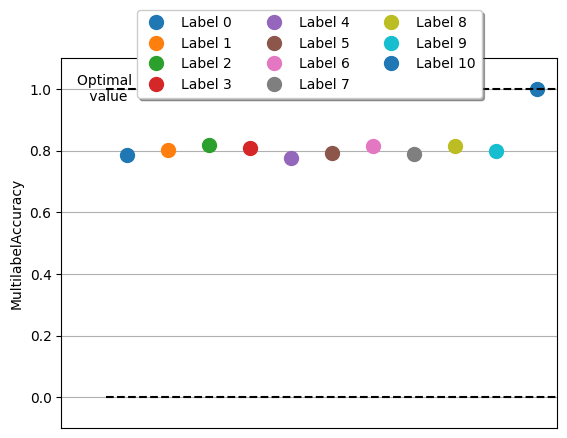

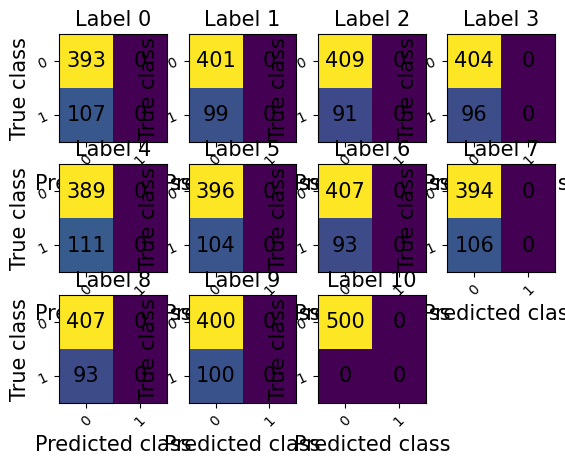

In [16]:
import torchmetrics
acc_list = []
sed_classifier = sed_classifier.to('cpu')
encoder = encoder.to('cpu')

multi_lab_acc = torchmetrics.classification.MultilabelAccuracy(num_labels=len(lab_dict)+1, average=None)
conf_mat = torchmetrics.classification.MultilabelConfusionMatrix(num_labels=len(lab_dict)+1)
for data in test_loader:

    sed_classifier.eval()
    encoder.eval()
    inpu, labs = data

    with torch.no_grad():
        repr = encoder.encoder(inpu)
        out_ = sed_classifier(repr)
        torch.round(out_)
    out_ = out_.to('cpu', torch.int)
    labs = labs.to('cpu', torch.int)
    multi_lab_acc.update(out_, labs)
    conf_mat.update(out_, labs)

fig1, ax1 = multi_lab_acc.plot()
fig2, ax2 = conf_mat.plot()

In [49]:
f1 = random.choice(df['file1'])
f2 = random.choice(df['file2'])
print(f1,f2)
noise = audio_utils.add_two_noise([f1,f2], [5])
featss = audio_utils.get_random_audioFeatures(noise)

encoder = encoder.cpu()
encoder.eval()
with torch.no_grad():
    repres = encoder.encoder(featss)

sed_classifier = sed_classifier.cpu()
sed_classifier.eval()
with torch.no_grad():
    out = sed_classifier(repres)

print(torch.round(torch.sigmoid(out)), lab_dict)

../audioData/NIGENS/NIGENS/knock/GLASS-HIT_GEN-HDF-12928.wav ../audioData/NIGENS/NIGENS/footsteps/FootstepsConGritt+6016_25_1.wav
tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.]]) {'alarm': 0, 'baby': 1, 'crash': 2, 'dog': 3, 'engine': 4, 'fire': 5, 'footsteps': 6, 'knock': 7, 'phone': 8, 'piano': 9}
